In [20]:
import sys
sys.path.append("../../")

from astronn import datasets
from astronn import models

import numpy as np
import matplotlib.pyplot as plt

#### Create a dataset with 1Mll theoretical stars oscilations

In [2]:
star_models = datasets.starmodels()
df = star_models.load("/home/roberto/Downloads/dataall_parts/*")

[<tf.Tensor 'DecodeCSV:1625' shape=() dtype=float32>]


#### Print sample vectors from Dataset

In [3]:
for row in df.take(1):
    print(row)

(<tf.Tensor: id=1718, shape=(150, 406, 3), dtype=float32, numpy=
array([[[ 0.    ,  1.    ,  1.    ],
        [ 0.    ,  0.    ,  0.9898],
        [ 0.    ,  0.    ,  0.9121],
        ...,
        [ 0.    ,  0.    ,  0.0285],
        [ 0.    ,  0.    ,  0.0129],
        [ 0.    ,  0.    ,  0.1729]],

       [[ 0.    ,  0.    ,  1.    ],
        [ 0.    ,  0.    ,  0.9893],
        [ 0.    ,  0.    ,  0.9078],
        ...,
        [ 0.    ,  0.    , -0.0143],
        [ 0.    ,  0.    , -0.0274],
        [ 0.    ,  0.    ,  0.2163]],

       [[ 0.    ,  2.    ,  1.    ],
        [ 0.    ,  1.    ,  0.9906],
        [ 0.    ,  1.    ,  0.9188],
        ...,
        [ 0.    ,  0.    , -0.0267],
        [ 0.    ,  0.    , -0.0421],
        [ 0.    ,  0.    ,  0.0641]],

       ...,

       [[ 0.    ,  0.    ,  1.    ],
        [ 0.    ,  1.    ,  0.9897],
        [ 0.    ,  0.    ,  0.9115],
        ...,
        [ 0.    ,  0.    , -0.0242],
        [ 0.    ,  0.    , -0.0209],
        [ 0. 

#### Create a Separable convolution model

In [5]:
sepconv_mod = models.separableconvnn() #init model
sepconv_mod.compile(learning_rate=0.0001) # compile model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 5)            140       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 393, 5)            155       
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 392, 5)            110       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 130, 5)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 5)            20        
_________________________________________________________________
dropout (Dropout)            (None, 130, 5)            0         
_________________________________________________________________
flatten (Flatten)            (None, 650)               0

#### Train model with dataset

In [7]:
history = sepconv_mod.fit(df, steps_per_epoch=100, epochs=20)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 8s 84ms/step - loss: 4.3662 - accuracy: 0.0150
Epoch 2/20
100/100 [==============================] - 8s 75ms/step - loss: 3.8693 - accuracy: 0.0165
Epoch 3/20
100/100 [==============================] - 8s 76ms/step - loss: 3.2997 - accuracy: 0.0173
Epoch 4/20
100/100 [==============================] - 8s 76ms/step - loss: 2.8265 - accuracy: 0.0183
Epoch 5/20
100/100 [==============================] - 8s 75ms/step - loss: 2.6657 - accuracy: 0.0188
Epoch 6/20
100/100 [==============================] - 8s 75ms/step - loss: 2.5226 - accuracy: 0.0172
Epoch 7/20
100/100 [==============================] - 8s 75ms/step - loss: 2.3403 - accuracy: 0.0174
Epoch 8/20
100/100 [==============================] - 8s 75ms/step - loss: 2.1054 - accuracy: 0.0187
Epoch 9/20
100/100 [==============================] - 8s 76ms/step - loss: 2.0982 - accuracy: 0.0192
Epoch 10/20
100/100 [==============================] - 7s 75ms/step - l

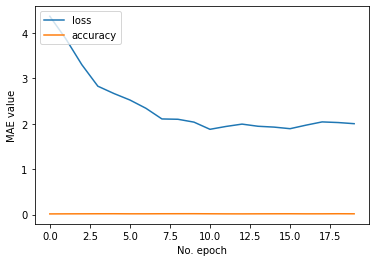

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### Save models and weigths on disk

In [8]:
sepconv_mod.save("/tmp/sepconvnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/sepconvnn/assets


#### Inference on one sample star

In [83]:
for row in df.take(1):
    print("Batch shape (%s %s)" % (row[0].shape, row[1].shape))
    # Select first row on the batch
    X_star_test = row[0][0].numpy()
    y_star_test = row[1][0].numpy()

y_hats = sepconv_mod.model.predict_classes(X_star_test.reshape(1, 406, 3))
print("\nInference: Y_hat=%s | Y_test=%s" % (y_hats, np.where(y_star_test[0]==1)[0]))

Batch shape ((150, 406, 3) (150, 1, 100))

Inference: Y_hat=[75] | Y_test=[74]
